In [77]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import unicodedata
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Sklearn utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Hugging Face Transformers and Datasets
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, ClassLabel

# Torch
import torch

nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chitrakumarsai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chitrakumarsai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
train_df = pd.read_csv('../data/raw/dataset/train.csv')
test_df = pd.read_csv('../data/raw/dataset/test.csv')

In [58]:
train_df.head()

,ID,Text,Subject
0,train_00001,"Its ""duet"" feature allows users to film a vide...",Pop Culture
1,train_00002,"*@**%%@ To support this, Blizzard released the...",Gaming
2,train_00003,"James Mitchell, the Premier of Western Austral...",History
3,train_00004,Pharo has an implementation of a heap in the C...,Computer Sciences
4,train_00005,"a for Tour, Alberto his his possible allowed m...",Sports


In [59]:
test_df.head()

,ID,Text
0,test_0001,Square's decision to produce games %*@*%@@ exc...
1,test_0002,Many of the properties in the Phase are set af...
2,test_0003,"As of at least 2015, Apple has removed legacy ..."
3,test_0004,Roman coins and medieval artefacts have all be...
4,test_0005,Thor: Love and Thunder is also set after Endgame


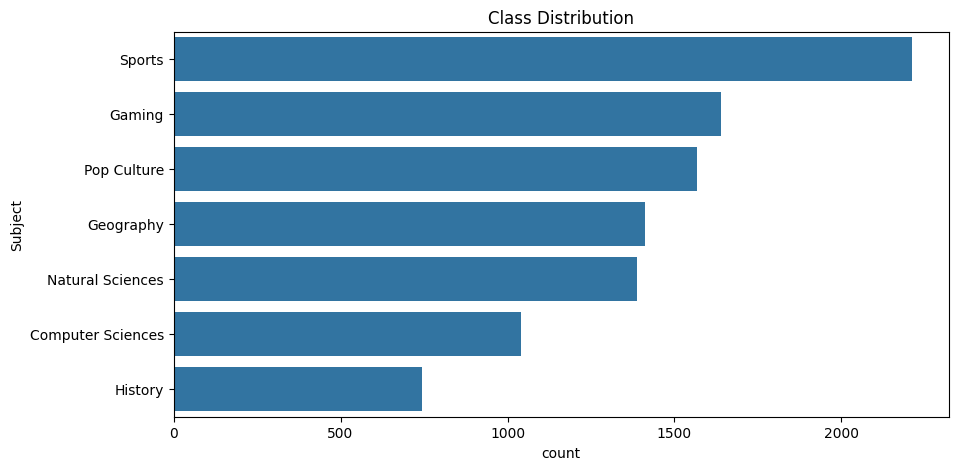

In [60]:
# Step 4: EDA
plt.figure(figsize=(10, 5))
sns.countplot(y='Subject', data=train_df, order=train_df['Subject'].value_counts().index)
plt.title("Class Distribution")
plt.show()

##  Sentence Length Analysis

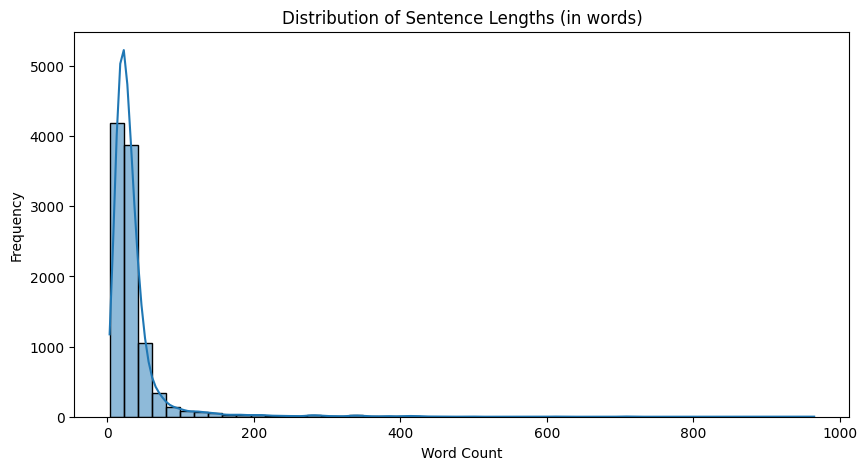

In [61]:
# Add length feature
train_df['text_length'] = train_df['Text'].apply(lambda x: len(str(x).split()))

# Plot length distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Sentence Lengths (in words)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Sentence Length by Class

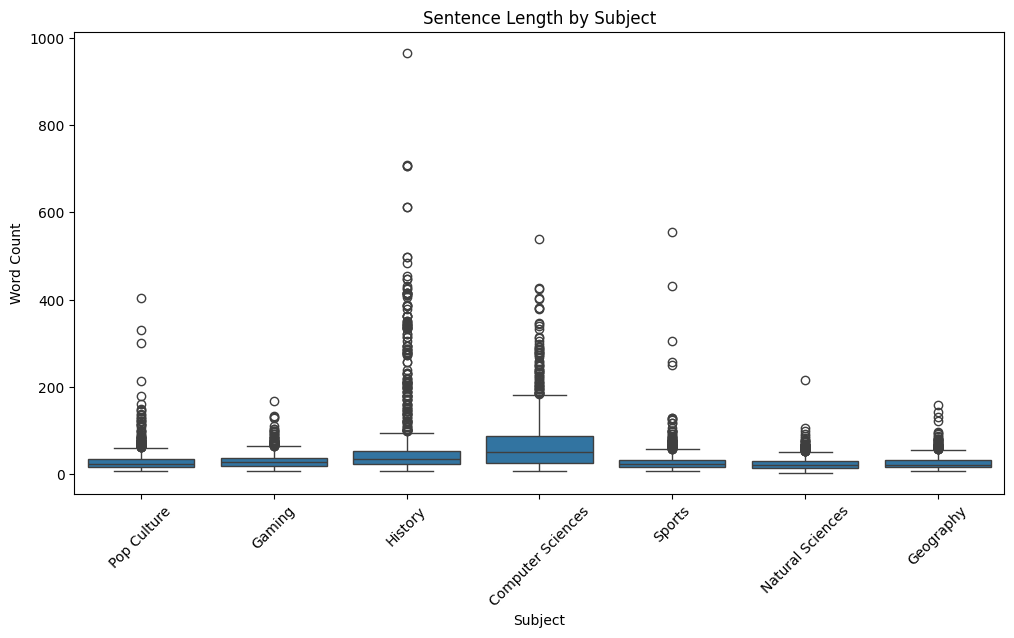

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='Subject', y='text_length')
plt.xticks(rotation=45)
plt.title('Sentence Length by Subject')
plt.ylabel('Word Count')
plt.show()

## Most Frequent Words per Class

In [69]:
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20):
    words = " ".join(texts).lower().split()
    words = [w for w in words if w not in stop_words and w.isalpha()]
    return Counter(words).most_common(n)

# Display top words by class
for label in train_df['Subject'].unique():
    top_words = get_top_words(train_df[train_df['Subject'] == label]['Clean_Text'], 15)
    print(f"\nTop words in '{label}':")
    for word, freq in top_words:
        print(f"{word}: {freq}")


Top words in 'Pop Culture':
korean: 208
pop: 191
marvel: 165
film: 163
music: 161
k: 156
also: 149
first: 142
tiktok: 129
game: 128
series: 119
electric: 116
award: 115
year: 109
one: 108

Top words in 'Gaming':
game: 1176
player: 353
steam: 248
world: 163
final: 161
character: 160
valve: 160
poke: 154
released: 151
also: 151
mon: 149
fantasy: 147
series: 141
first: 139
one: 137

Top words in 'History':
french: 260
war: 205
attack: 192
british: 157
army: 155
one: 136
japanese: 133
would: 129
two: 121
revolution: 117
first: 117
state: 115
force: 111
american: 97
general: 96

Top words in 'Computer Sciences':
system: 691
data: 459
language: 297
computer: 258
user: 257
used: 253
operating: 230
kernel: 229
time: 229
also: 221
memory: 220
program: 210
application: 191
may: 188
use: 188

Top words in 'Sports':
team: 459
game: 382
league: 350
first: 316
super: 305
bowl: 293
year: 226
season: 225
time: 223
two: 191
tour: 183
player: 181
world: 169
club: 167
one: 154

Top words in 'Natural Sci

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chitrakumarsai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Word Clouds by Subject

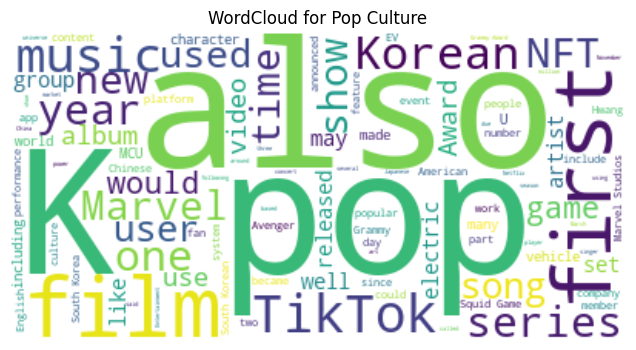

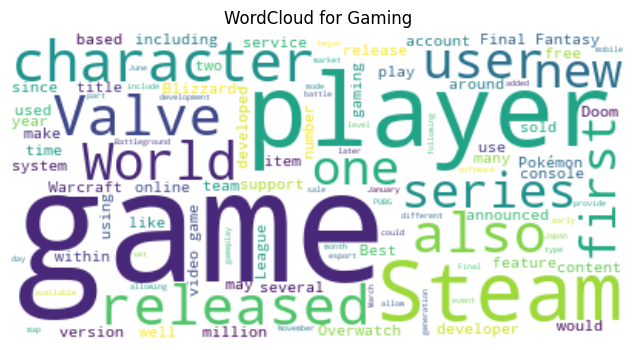

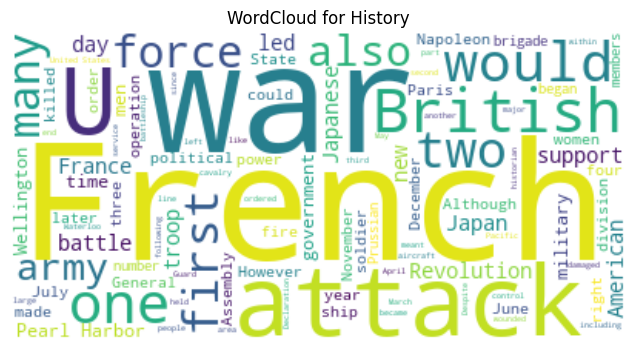

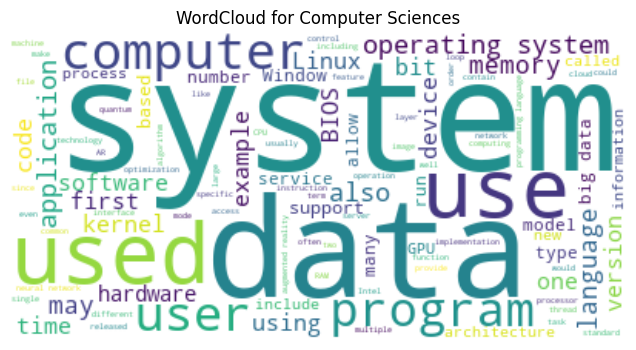

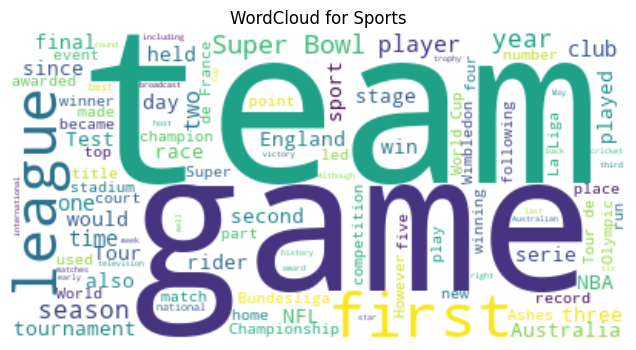

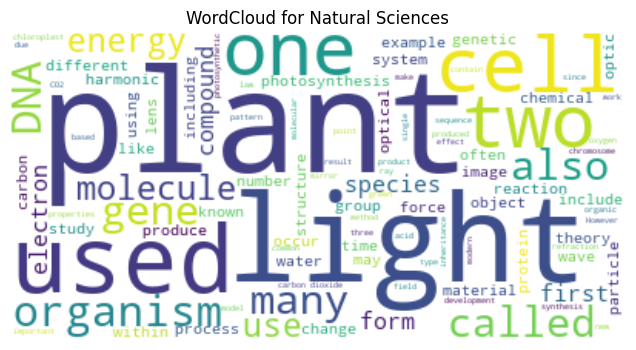

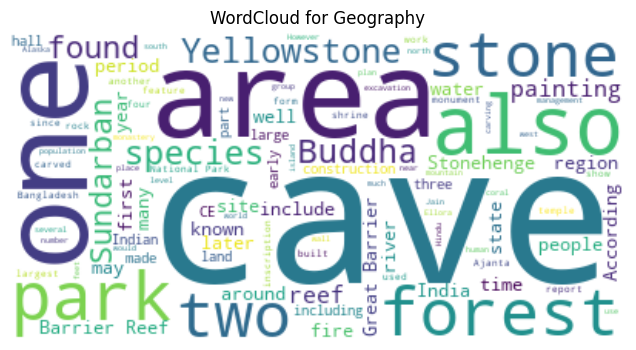

In [64]:
for subject in train_df['Subject'].unique():
    subset = train_df[train_df['Subject'] == subject]
    text = " ".join(subset['Text'].astype(str).tolist())
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {subject}")
    plt.show()

## Class Overlap Check via TF-IDF + PCA/TSNE (Optional Visualization)

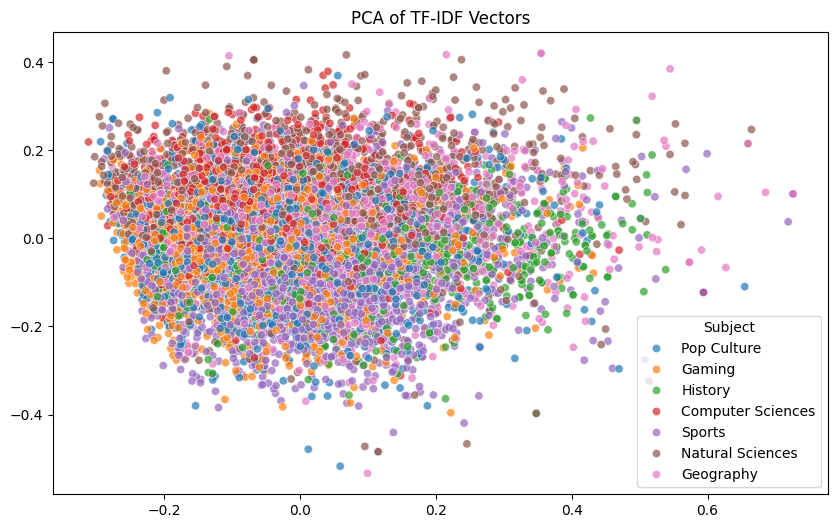

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# TF-IDF vectors
tfidf = TfidfVectorizer(max_features=300)
X = tfidf.fit_transform(train_df['Text'])

# Reduce dimensions
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=train_df['Subject'], palette='tab10', alpha=0.7)
plt.title("PCA of TF-IDF Vectors")
plt.show()

## STEP 1: Data Preprocessing

In [66]:
# Use a single robust clean_text function with lemmatization and stopword removal
import re
import string
import unicodedata
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""
    # Normalize Unicode (remove accents, control characters)
    text = unicodedata.normalize("NFKD", text)
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove URLs and emails
    text = re.sub(r"http\S+|www\S+|\S+@\S+", "", text)
    # Remove mentions like @username
    text = re.sub(r"@\w+", "", text)
    # Remove emojis and non-alphanumeric (except punctuation)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r"[^a-zA-Z0-9.,!?'\"]+", ' ', text)
    # Lowercase
    text = text.lower()
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenize and remove stopwords, lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chitrakumarsai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chitrakumarsai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chitrakumarsai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [76]:
# Step 1: Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score

# Step 2: Load data
train_df = pd.read_csv('../data/raw/dataset/train.csv')
test_df = pd.read_csv('../data/raw/dataset/test.csv')
train_df['Clean_Text'] = train_df['Text'].astype(str).apply(clean_text)
test_df['Clean_Text'] = test_df['Text'].astype(str).apply(clean_text)
# Step 3: Encode labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['Subject'])

# Step 4: Build TF-IDF + Logistic Regression pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        sublinear_tf=True,        # Apply sublinear scaling
        min_df=3,                 # Ignore very rare words
        norm='l2',                # L2 normalize
        encoding='utf-8',
        ngram_range=(1, 2),       # Use unigrams + bigrams
        stop_words='english'      # Remove English stopwords
    )),
    ('clf', LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    solver='saga',          # supports sparse + multinomial
    multi_class='multinomial'
)),
])

# Step 5: Train model
pipeline.fit(train_df['Clean_Text'], train_df['label'])

# Step 6: Evaluate on training set (optional)
train_preds = pipeline.predict(train_df['Clean_Text'])
print(classification_report(train_df['label'], train_preds, target_names=label_encoder.classes_))
print("Macro F1:", f1_score(train_df['label'], train_preds, average='macro'))

# Step 7: Predict on test set
test_preds = pipeline.predict(test_df['Clean_Text'])
test_df['Subject'] = label_encoder.inverse_transform(test_preds)

# Step 8: Save submission file
submission = test_df[['ID', 'Subject']]
submission.to_csv("../results/submission.csv", index=False)
print("submission.csv saved!")

/Users/chitrakumarsai/Desktop/Personal/projects/fractal_ml_casestudy/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                   precision    recall  f1-score   support

Computer Sciences       0.93      0.94      0.93      1039
           Gaming       0.93      0.93      0.93      1640
        Geography       0.95      0.94      0.95      1413
          History       0.93      0.96      0.95       743
 Natural Sciences       0.93      0.95      0.94      1389
      Pop Culture       0.94      0.92      0.93      1566
           Sports       0.94      0.93      0.94      2210

         accuracy                           0.94     10000
        macro avg       0.94      0.94      0.94     10000
     weighted avg       0.94      0.94      0.94     10000

Macro F1: 0.9379168390926047
submission.csv saved!
